## Import required modules

In [2]:
# help function
from transfer_learning import NeuralNet
from dataset_loader import data_loader, all_filter, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import os, sys
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
from scipy.stats import pearsonr

import matplotlib.pyplot as plt 
%matplotlib inline

# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

## Load the dataset

In [4]:
"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)

# extract descriptors and gas adsorptions
one_property = one_filter(data, another_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )
print(X.shape)
print(y.shape)
X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)

(13506, 5)
(13506,)


## Source task training

100%|██████████| 5000/5000 [00:50<00:00, 98.68it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'Manuscript/H2_val.png'

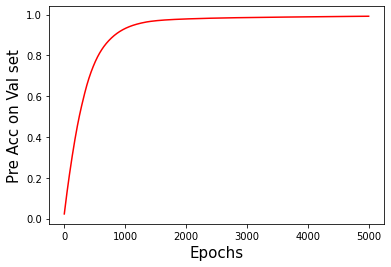

In [7]:
## hyper-parameters
input_size = 5
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1
learning_rate = 0.00002

## model, loss, and optimizer
model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## train, val, test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Training
scores_epochs = list()
num_epochs = 5000

for epoch in tqdm(range(num_epochs)):
    inputs = torch.from_numpy(X_train)
    labels = torch.from_numpy(y_train)

    outputs = model(inputs).view(-1,)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        inputs_val = torch.from_numpy(X_val)
        labels_val = torch.from_numpy(y_val)

        outputs_val = model(inputs_val).view(-1,)
        score = r2_score(labels_val.data.numpy(), outputs_val.data.numpy())
#         print('Predictive accuracy on validation set at epoch {}/{} is {}'.format(epoch, num_epochs, score)) 
        scores_epochs.append(score)
#     if len(scores_epochs) >= 2:
#             if score < scores_epochs[-2]:
#                 break

# torch.save(model.state_dict(), 'model_H2.ckpt')  
plt.plot(np.arange(0, num_epochs, 5), scores_epochs, color='red')
plt.xlabel('Epochs', size=15)
plt.ylabel('Pre Acc on Val set', size=15)
plt.savefig('Manuscript/H2_val.png', bbox_inches='tight', dpi=500)
print('The predictive accuracy on test set is {}'.format(
                r2_score(torch.from_numpy(y_test).data.numpy(), model(torch.from_numpy(X_test)).view(-1,).data.numpy())))


## Direct learning and transfer learning on target tasks

In [8]:
def transfer_learning(transfer=False, nsamples=None, nbatches=None,name):
    seeds = np.arange(nbatches)
    Ns = list()
    scores_epochs = list()
    scores_test = list()
    scores_train = list()

    pred_tests = list()
    grt_train_X = list()
    grt_test_X = list()
    grt_tests = list()

    for seed in tqdm(seeds):
        data_small = data.sample(n=nsamples, random_state=seed)

        another_property = one_filter(data_small, another_filter_columns)
        descriptors_small = get_descriptors(data_small, descriptor_columns)

        X_small = np.array(descriptors_small.values, dtype=np.float32)
        y_small = np.array(another_property.values, dtype=np.float32).reshape(len(X_small), )
        
        X_small = data_scaler(X_small)
        y_small = data_scaler(y_small.reshape(-1, 1)).reshape(len(X_small),)

        ## hyper-parameters
        input_size = 5
        hidden_size_1 = 128
        hidden_size_2 = 64
        output_size = 1
        learning_rate = 0.00002

        ## model, loss, and optimizer
        if transfer:
            model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
            model.load_state_dict(torch.load('model_H2.ckpt'))
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False

            criterion = nn.MSELoss()
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
        else:
            model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
            
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        ## train, val, test data split
        X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.1, random_state=1)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

        scores_epoch = list()
        num_epochs = 10000
        N = 0
        for epoch in range(num_epochs):
            inputs = torch.from_numpy(X_train)
            labels = torch.from_numpy(y_train)

            outputs = model(inputs).view(-1,)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            N += 1
            if epoch % 5 == 0:
                inputs_val = torch.from_numpy(X_val)
                labels_val = torch.from_numpy(y_val)

                outputs_val = model(inputs_val).view(-1,)
                score = r2_score(labels_val.data.numpy(), outputs_val.data.numpy())
        #         print('Predictive accuracy on validation set at epoch {}/{} is {}'.format(epoch, num_epochs, score)) 
                scores_epoch.append(score)
            if len(scores_epoch) >= 2:
                if score < scores_epoch[-2]:
                    break
        scores_epochs.append(scores_epoch)
        Ns.append(N)
    
        score_train = r2_score(torch.from_numpy(y_train).data.numpy(), model(torch.from_numpy(X_train)).view(-1,).data.numpy())     
#         score_train = mean_squared_error(torch.from_numpy(y_train).data.numpy(), model(torch.from_numpy(X_train)).view(-1,).data.numpy())     
        scores_train.append(score_train)
    
        pred_tests.append(model(torch.from_numpy(X_test)).view(-1,).data.numpy())
        grt_train_X.append(torch.from_numpy(X_train).data.numpy())
        grt_test_X.append(torch.from_numpy(X_test).data.numpy())
        grt_tests.append(torch.from_numpy(y_test).data.numpy())
        score_test = r2_score(torch.from_numpy(y_test).data.numpy(), model(torch.from_numpy(X_test)).view(-1,).data.numpy())
#         score_test = mean_squared_error(torch.from_numpy(y_test).data.numpy(), model(torch.from_numpy(X_test)).view(-1,).data.numpy())
        scores_test.append(score_test)
        torch.save(model, f'{name}.pt')
    return scores_train, scores_test, grt_train_X, grt_test_X


## Direct learning

In [9]:
scores_train_H2_130K_wo_transfer, scores_test_H2_130K_wo_transfer, grt_train_X_wo_transfer, grt_test_X_wo_transfer = transfer_learning(transfer=False, nsamples=100, nbatches=1000,"One")


100%|██████████| 1000/1000 [1:09:00<00:00,  4.14s/it]


## Transfer learning

In [10]:
scores_train_H2_130K_w_transfer, scores_test_H2_130K_w_transfer, grt_train_X_w_transfer, grt_test_X_w_transfer = transfer_learning(transfer=True, nsamples=100, nbatches=1000,"Two")     


100%|██████████| 1000/1000 [35:26<00:00,  2.13s/it]
